# Intersection Research
The purpose of this notebook is to try to answer the following questions from a small area:

1. What intersections are within my jurisdiction?
1. Where exactly are the intersections located?
1. What does a particular intersection look like?
1. What are the intersection names? 
1. Given an intersection, what are the nearby intersections? (Optional for initial research)
1. What attributes of intersections do we know of, such as number of lanes, control signals, signage, etc?
1. Where have traffic incidents occurred?

### Requirements
The OSMnx library has a dependency on the RTree library, which has a dependency on libspatialindex, which is not a Python package. Before trying to install OSMnx, first install libspatialindex. 

If you are on Mac, you should be able to run `brew install spatialindex`.

After that, you should be able to pip install the following requirements:
`matplotlib`
`osmnx`
`jupyter`
`requests-cache`

In [1]:
from IPython.display import Image, display
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd
import osmnx as ox
import pandas as pd

import os

# Local package imports
from dot.osm import get_graph_from_place, get_graph_from_point, graph_to_nodes
from dot.tiles import lat_lon_to_tile, get_tile_url, get_tile_img, lat_lon_to_proportion
from dot.tiles import draw_square_at_proportion, draw_square_at_pixel, get_cropped_centered_img

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.16.1'

Acceptance criteria #1: should be able to gather map data within a specified region.

Example:
#### Plot of Roadway Points in Arlington County:

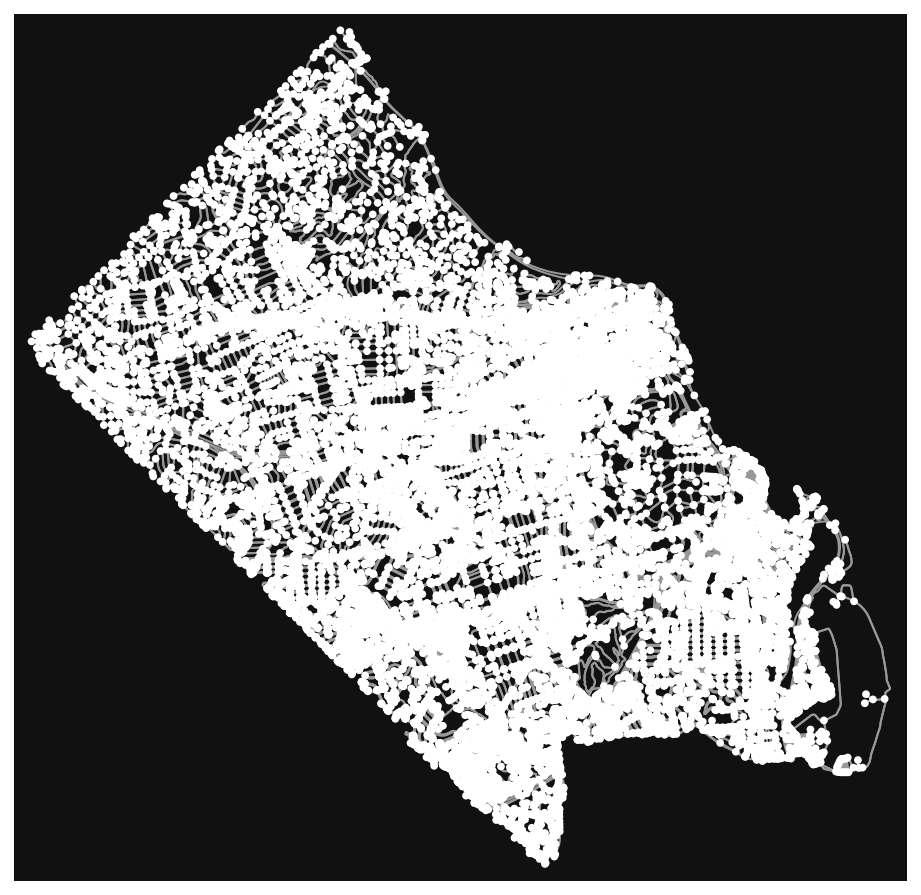

In [2]:
G = get_graph_from_place('Arlington County, Virginia, US')
fig, ax = ox.plot_graph(G, figsize=(1,1), dpi=256)

#### Roadways: Intersections (red) and Non-Intersection Points (yellow)
Non-intersection points (nodes) are used to give roadways non-straight shapes. We do not need them for our initial intersection analysis.

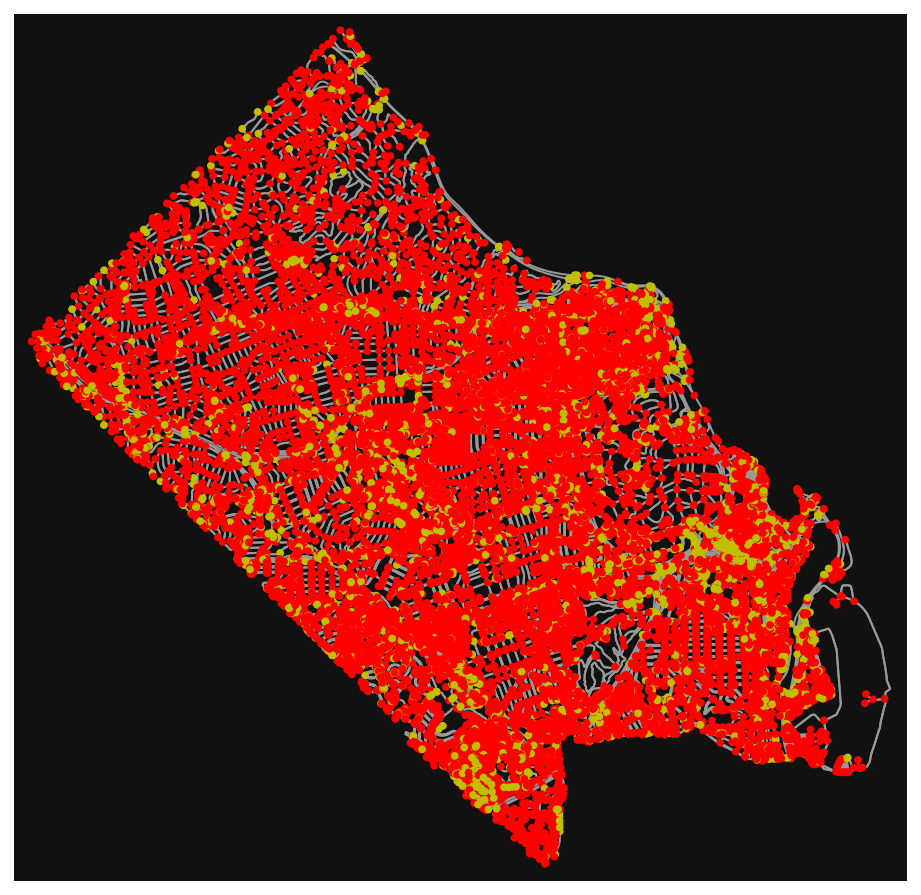

In [3]:
nc = ['r' if ox.simplification._is_endpoint(G, node) else 'y' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

#### Roadways: Intersections only

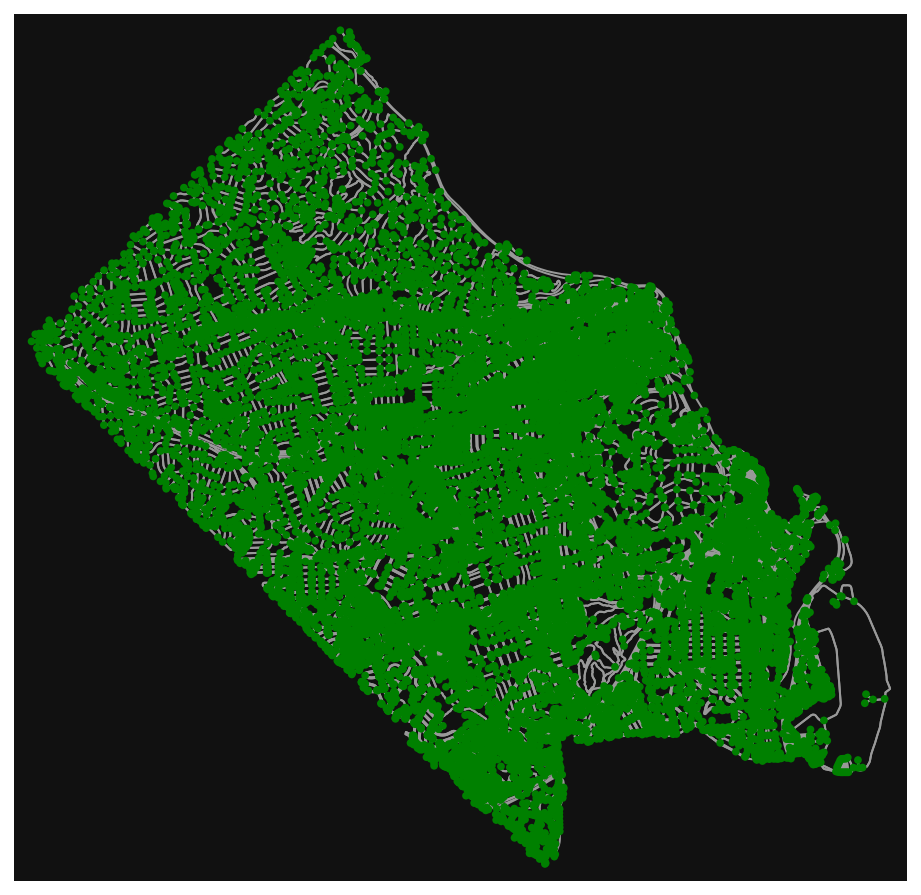

In [4]:
fig, ax = ox.plot_graph(G, node_color='g')

#### Zoom in to an area of Crystal City (Arlington) with complex roadways

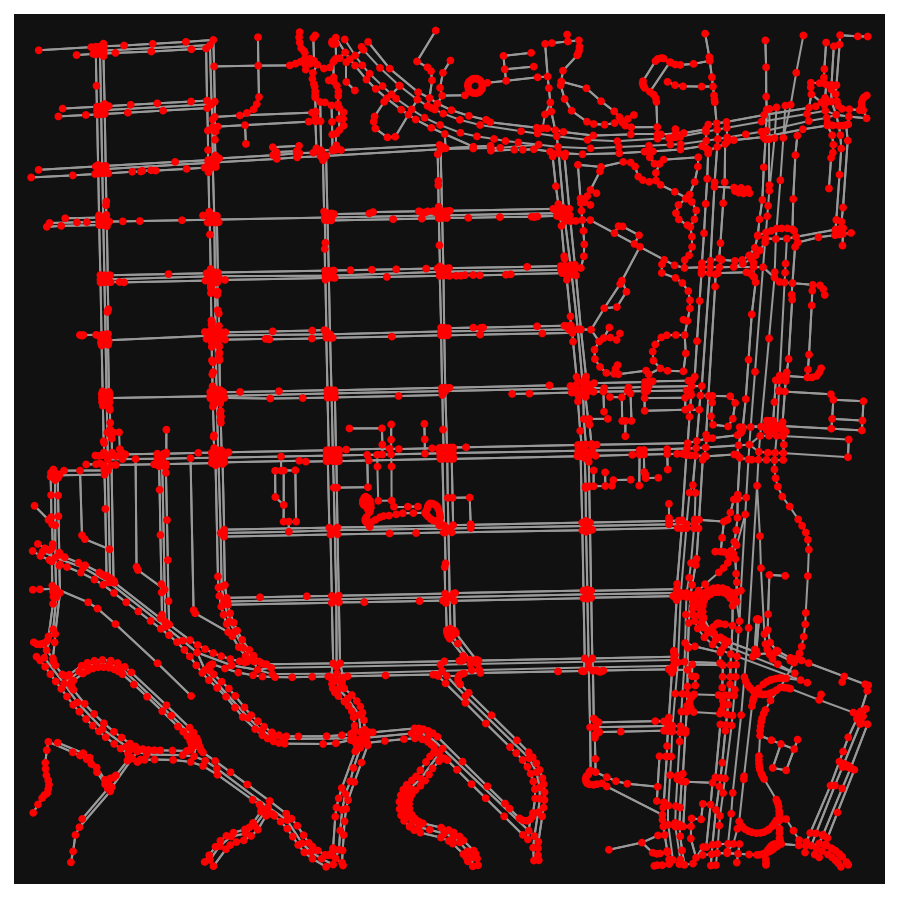

In [5]:
location_point = (38.853361, -77.057516)
G = get_graph_from_point(location_point, dist=600)
fig, ax = ox.plot_graph(G, node_color='r')

Acceptance criteria #2: should be able to identify and list intersections within a specified region

Example identifying intersections:

#### Show which nodes will be removed if we simplify it (yellow)
In some locations, multiple intersection points are consolidated to a single intersetction point, such as when roadways with multiple services converge.

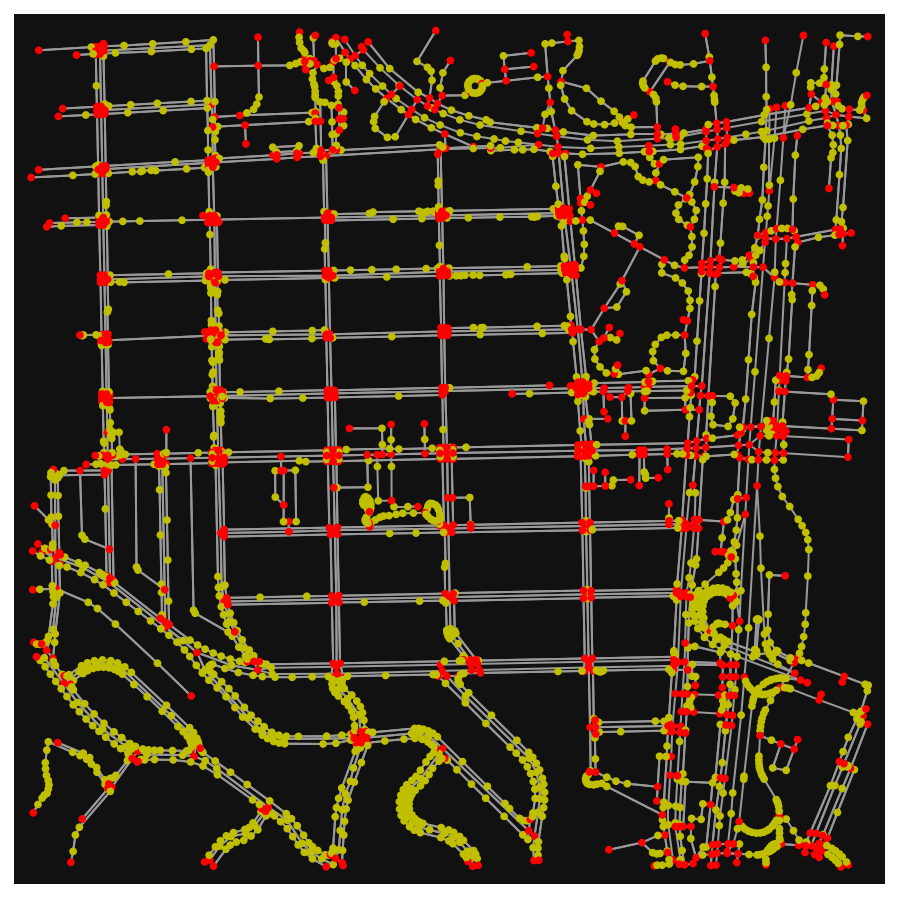

In [6]:
nc = ['r' if ox.simplification._is_endpoint(G, node) else 'y' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

#### The simplified interserctions

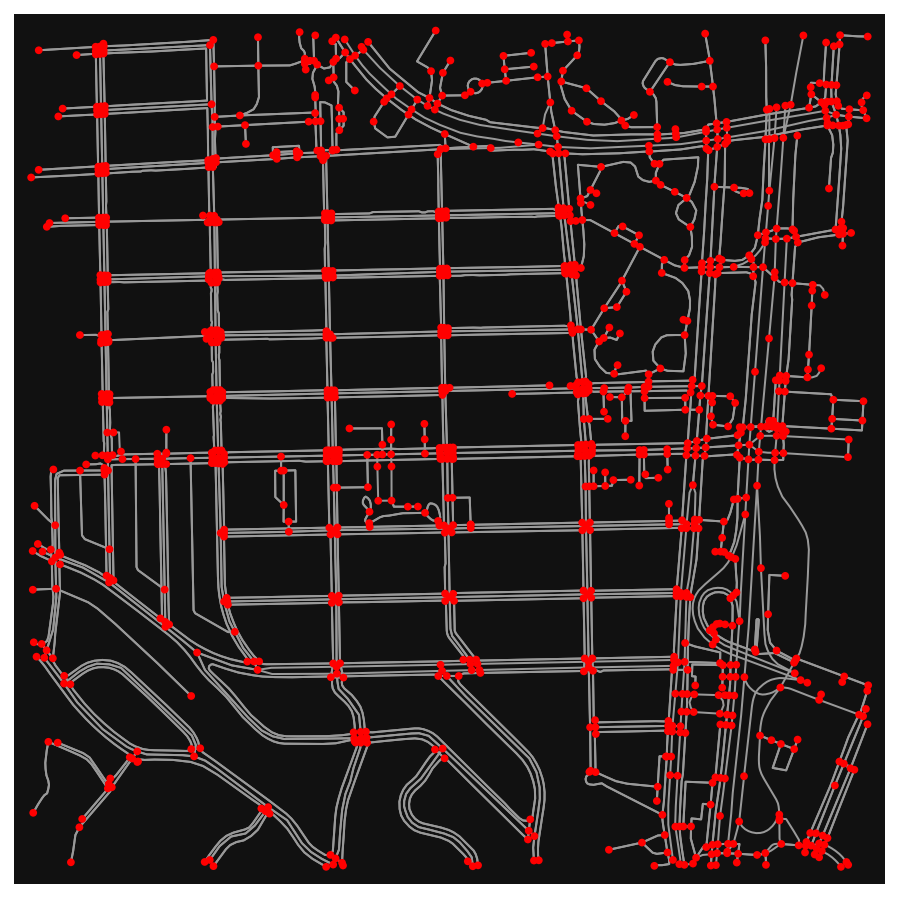

In [7]:
G2 = ox.simplify_graph(G.copy(), strict=False)
fig, ax = ox.plot_graph(G2, node_color='r')

Acceptance criteria #2: should be able to identify and list intersections within a specified region

Example showing the first 10 intersections in the list of Arlington County intersections:

In [8]:
nodes = graph_to_nodes(G)
nodes[:10]

[(63330379,
  {'y': 38.8557012,
   'x': -77.0532041,
   'osmid': 63330379,
   'highway': 'traffic_signals'}),
 (63331109, {'y': 38.8548975, 'x': -77.0553943, 'osmid': 63331109}),
 (63332463, {'y': 38.8556406, 'x': -77.0555019, 'osmid': 63332463}),
 (63332513, {'y': 38.8489205, 'x': -77.0529891, 'osmid': 63332513}),
 (63332892,
  {'y': 38.8560662,
   'x': -77.0519344,
   'osmid': 63332892,
   'highway': 'traffic_signals'}),
 (63332897, {'y': 38.8561832, 'x': -77.0511298, 'osmid': 63332897}),
 (63332899, {'y': 38.856308, 'x': -77.0511158, 'osmid': 63332899}),
 (63332903, {'y': 38.8572282, 'x': -77.0510345, 'osmid': 63332903}),
 (63332911, {'y': 38.8579886, 'x': -77.0511998, 'osmid': 63332911}),
 (63336720,
  {'y': 38.8482418,
   'x': -77.051531,
   'osmid': 63336720,
   'highway': 'traffic_signals'})]

#### Process the nodes and get satellite images for each

In [9]:
# Enter your mapbox token or load it from environment variable here
mapbox_token = os.getenv('MAPBOX_TOKEN')

In [10]:
lat, lon = nodes[1][1]['y'], nodes[1][1]['x']
img_urls = []
for zoom in [18, 17, 16]:
    x, y = lat_lon_to_tile(lat, lon, zoom)
    url = get_tile_url(x, y, zoom=zoom)
    img_urls.append({'url': url, 'zoom': zoom, 'lat': lat, 'lon': lon})

In [11]:
img_urls

[{'url': 'https://api.mapbox.com/v4/mapbox.satellite/18/74961/100321.jpg70?access_token=pk.eyJ1IjoiZHJ3YXRlcm1hbiIsImEiOiJja2diM2VzcTcwZGVhMzFtZmt5M2dydDNqIn0.Sw9Z0XNEnGiJubbTE7oPBw',
  'zoom': 18,
  'lat': 38.8548975,
  'lon': -77.0553943},
 {'url': 'https://api.mapbox.com/v4/mapbox.satellite/17/37480/50160.jpg70?access_token=pk.eyJ1IjoiZHJ3YXRlcm1hbiIsImEiOiJja2diM2VzcTcwZGVhMzFtZmt5M2dydDNqIn0.Sw9Z0XNEnGiJubbTE7oPBw',
  'zoom': 17,
  'lat': 38.8548975,
  'lon': -77.0553943},
 {'url': 'https://api.mapbox.com/v4/mapbox.satellite/16/18740/25080.jpg70?access_token=pk.eyJ1IjoiZHJ3YXRlcm1hbiIsImEiOiJja2diM2VzcTcwZGVhMzFtZmt5M2dydDNqIn0.Sw9Z0XNEnGiJubbTE7oPBw',
  'zoom': 16,
  'lat': 38.8548975,
  'lon': -77.0553943}]

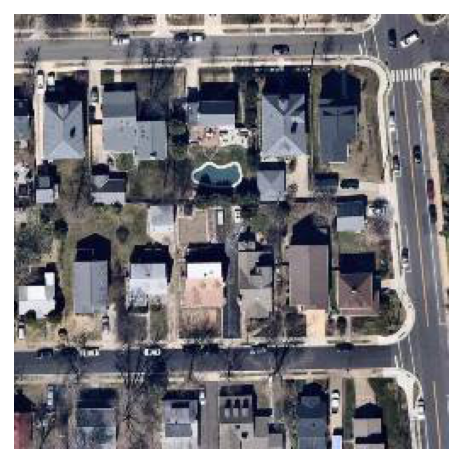

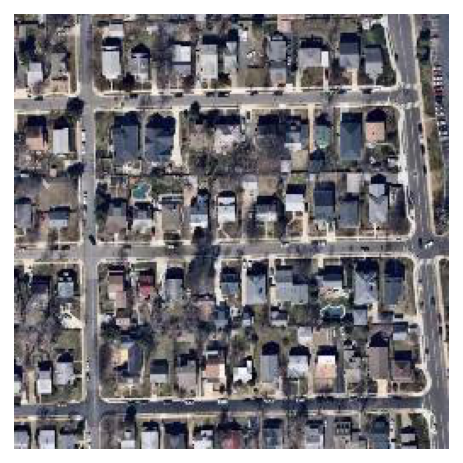

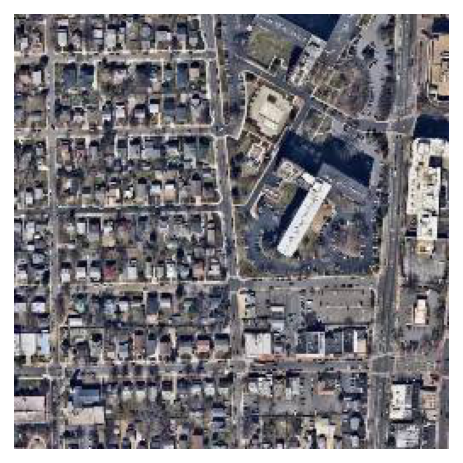

In [12]:
for img_url in img_urls:
    image = io.imread(img_url['url'])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Acceptance Criteria #3: should be able to identify location of intersections and collect satellite imagery identifying the intersection location

Example showing different levels of zoom for a single intersection, with location of intersection marked by red box:

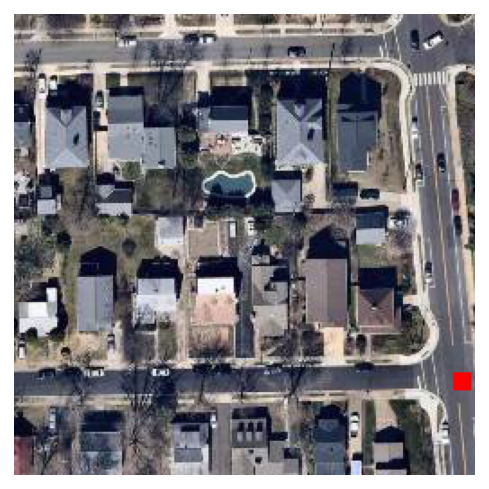

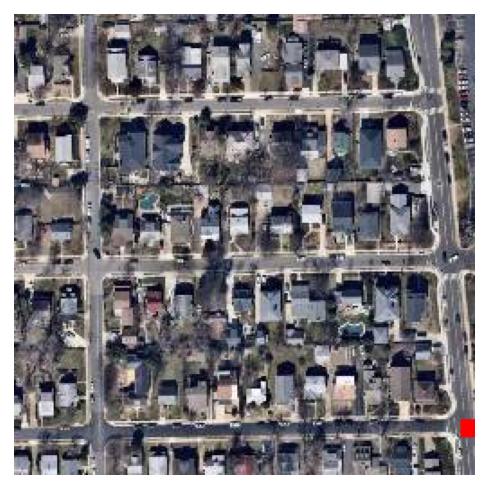

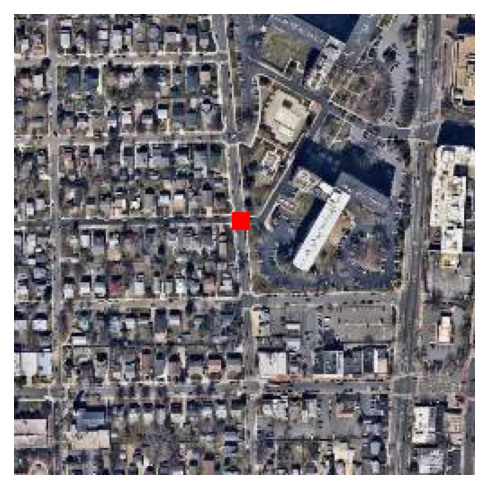

In [13]:
for img_url in img_urls:
    img = mpimg.imread(img_url['url'], format='jpg')
    x_pct, y_pct = lat_lon_to_proportion(img_url['lat'], img_url['lon'], img_url['zoom'])
    img = draw_square_at_proportion(img, x_pct, y_pct)
    # Update figure size based on image size
    height, width, bands = img.shape
    dpi = 80
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    figure = plt.figure(figsize=figsize)
    axes = figure.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    axes.axis('off')
    axes.imshow(img)

## DRWS-28: Get cropped & centered satellite imagery of intersection

Return satellite image at zoom level 18

Image should be 256x256 pixels

Center of image should align with intersection

Mark center of intersection with red dot

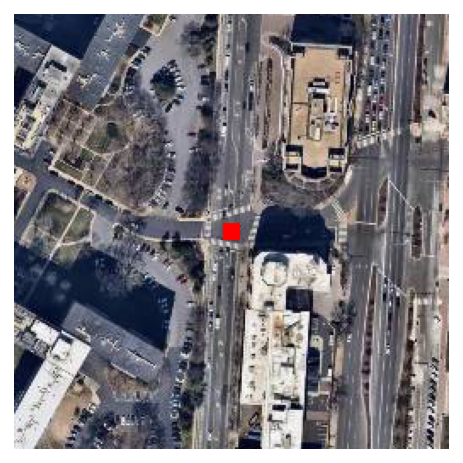

In [14]:
lat = 38.8557012
lon = -77.0532041

plt.imshow(get_cropped_centered_img(lat, lon, mapbox_token, zoom=17))
plt.axis('off')
plt.show()

## DRWS-27: Get image of intersection with every known incident location marked

Given an intersection location:

* Return a 256x256 pixel image centered on the intersection

* Every known incident location that lies within the image should be marked

* Markers should be small (size TBD) transparent circles

### Get the image centered at the given lat/lon and find the coordinates of its edges:

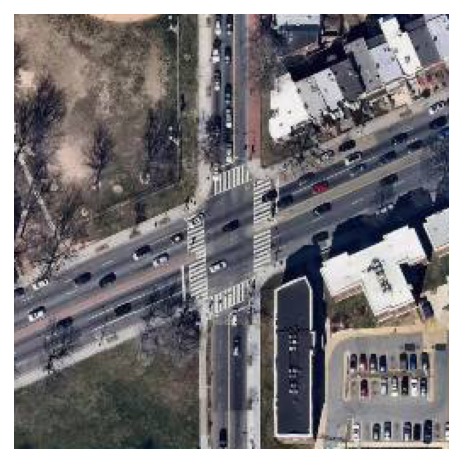

Lat min: 38.905799906249996, Lat max: 38.90679209375
Lon min: -77.01265909375, Lon max: -77.01166690625


In [15]:
lat, lon = 38.906296, -77.012163

ZOOM_LEVEL = 18
TILE_WIDTH = {
    # Zoom level: Tile width in degrees of longitude
    18: 0.001,
    17: 0.003,
    16: 0.005,
    15: 0.011,
    14: 0.022,
    13: 0.044,
    12: 0.088,
    11: 0.176,
    10: 0.352,
    9: 0.703,
}

plt.imshow(get_cropped_centered_img(lat, lon, mapbox_token, zoom=ZOOM_LEVEL, mark_point=False))
plt.axis('off')
plt.show()

# Find the lat/lon of the edges of the image
x_min = lat - TILE_WIDTH[ZOOM_LEVEL] * (127 / 256)
x_max = lat + TILE_WIDTH[ZOOM_LEVEL] * (127 / 256)
y_min = lon - TILE_WIDTH[ZOOM_LEVEL] * (127 / 256)
y_max = lon + TILE_WIDTH[ZOOM_LEVEL] * (127 / 256)

print(f"Lat min: {x_min}, Lat max: {x_max}")
print(f"Lon min: {y_min}, Lon max: {y_max}")

### Load the DC Crash data and extract the locations that will be visible on this image:

In [16]:
crashes = pd.read_csv('../data/Crashes_in_DC.csv', low_memory=False)
visible_crashes = crashes[(crashes['LATITUDE'] > x_min) & (crashes['LATITUDE'] < x_max) & (crashes['LONGITUDE'] > y_min) & (crashes['LONGITUDE'] < y_max)]
print(f"Found {len(visible_crashes)} crashes on this image")

Found 188 crashes on this image


### Draw a semi-transparent circle at each crash location:

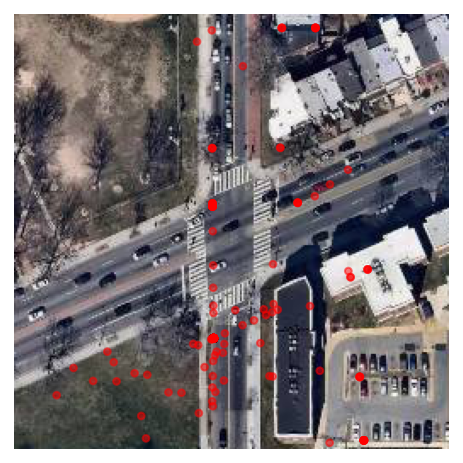

In [17]:
plt.imshow(get_cropped_centered_img(lat, lon, mapbox_token, zoom=ZOOM_LEVEL, mark_point=False))
plt.axis('off')
for idx, (crash_lat, crash_lon) in visible_crashes[['LATITUDE', 'LONGITUDE']].iterrows():
    x_prop, y_prop = lat_lon_to_proportion(crash_lat, crash_lon, ZOOM_LEVEL)
    x_px = x_prop * 256
    y_px = y_prop * 256
    
    circle = plt.Circle((x_px, y_px), radius=2, facecolor='red',
         edgecolor='red', linewidth='1', alpha = 0.5)
    plt.gca().add_patch(circle)    

plt.show()